In [14]:
#import libraries
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd

In [2]:
!wget https://www.orand.cl/orand_car/ORAND-CAR-2014.tar.gz

!tar -xzvf /content/ORAND-CAR-2014.tar.gz

Streaming output truncated to the last 5000 lines.
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004006.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_003727.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004368.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_006406.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005617.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005230.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_003850.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_003293.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004967.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005234.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005513.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_003051.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004463.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005193.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004030.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_004672.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_003002.png
ORAND-CAR-2014/CAR-B/b_train_images/b_car_005737

In [3]:
!pip install Levenshtein
import Levenshtein as lv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 69.5 MB/s eta 0:00:00


In [4]:
# Define paths for CAR-A
pth = "/content/ORAND-CAR-2014/CAR-A"
img_train_dataset_a = f'{pth}/a_train_images'
train_dataset_file_a = f'{pth}/a_train_gt.txt'
img_test_dataset_a = f'{pth}/a_test_images'
test_dataset_file_a = f'{pth}/a_test_gt.txt'

# Define paths for CAR-B
pth_b = "/content/ORAND-CAR-2014/CAR-B"
img_train_dataset_b = f'{pth_b}/b_train_images'
train_dataset_file_b = f'{pth_b}/b_train_gt.txt'
img_test_dataset_b = f'{pth_b}/b_test_images'
test_dataset_file_b = f'{pth_b}/b_test_gt.txt'

In [5]:
# Initialize variables
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

char_list = "0123456789"

def encode_to_labels(txt):
    # Encoding each output word into digits
    dig_lst = []
    for chara in txt:
        dig_lst.append(char_list.index(chara))
    return dig_lst

def process_image(img, target_h=64, target_w=220):
    img = cv2.resize(img, (target_w, target_h))
    img = img.astype('float32')
    img = np.expand_dims(img, axis=2)
    img = img / 255
    return img

def load_data(img_path, lbl_path):
    images = []
    labels = []
    input_length = []
    label_length = []
    original_text = []

    with open(lbl_path, 'r') as file:
        lines = file.readlines()

    for index, line in enumerate(lines):
        image_path, label = line.strip().split()
        image_path = os.path.join(img_path, image_path)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if img is not None:
            img = process_image(img)
            label = encode_to_labels(label)

            images.append(img)
            labels.append(label)
            input_length.append(55)  # Updated input length based on resized image width
            label_length.append(len(label))
            original_text.append(label)

    return images, labels, input_length, label_length, original_text

# Load datasets
train_images_a, train_labels_a, train_input_length_a, train_label_length_a, train_original_text_a = load_data(img_train_dataset_a, train_dataset_file_a)
valid_images_a, valid_labels_a, valid_input_length_a, valid_label_length_a, valid_original_text_a = load_data(img_test_dataset_a, test_dataset_file_a)

train_images_b, train_labels_b, train_input_length_b, train_label_length_b, train_original_text_b = load_data(img_train_dataset_b, train_dataset_file_b)
valid_images_b, valid_labels_b, valid_input_length_b, valid_label_length_b, valid_original_text_b = load_data(img_test_dataset_b, test_dataset_file_b)

# Merge datasets
train_images = train_images_a + train_images_b
train_labels = train_labels_a + train_labels_b
train_input_length = train_input_length_a + train_input_length_b
train_label_length = train_label_length_a + train_label_length_b
train_original_text = train_original_text_a + train_original_text_b

valid_images = valid_images_a + valid_images_b
valid_labels = valid_labels_a + valid_labels_b
valid_input_length = valid_input_length_a + valid_input_length_b
valid_label_length = valid_label_length_a + valid_label_length_b
valid_original_text = valid_original_text_a + valid_original_text_b

# Padding labels
max_label_len = max(max(train_label_length), max(valid_label_length))
train_padded_label = pad_sequences(train_labels, maxlen=max_label_len, padding='post', value=len(char_list))
valid_padded_label = pad_sequences(valid_labels, maxlen=max_label_len, padding='post', value=len(char_list))
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [6]:
def Model1():
    inputs = Input(shape=(64, 220, 1))

    conv_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

    conv_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

    conv_3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool_2)
    conv_4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_3)
    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

    conv_5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool_4)
    batch_norm_5 = BatchNormalization()(conv_5)

    conv_6 = Conv2D(512, (3, 3), activation='relu', padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

    conv_7 = Conv2D(512, (2, 2), activation='relu')(pool_6)

    reshaped = Reshape((54 * 3, 512))(conv_7)

    blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(reshaped)
    blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(blstm_1)

    outputs = Dense(len(char_list) + 1, activation='softmax')(blstm_2)

    act_model = Model(inputs, outputs)
    return act_model, outputs, inputs

act_model, outputs, inputs = Model1()

the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

# Use Adam optimizer for potentially better performance
optimizer = Adam(learning_rate=0.001)

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer, metrics=['accuracy'])

filepath = "/content/crnn_model.keras"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=32,  # Increased batch size
                    epochs=20,
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1,
                    callbacks=callbacks_list)

model.save(filepath='./model_crnn.h5', overwrite=False, include_optimizer=True)

# Performance Check: Levenshtein Distance

act_model.load_weights(filepath)

prediction = act_model.predict(valid_images)
decoded = tf.keras.backend.ctc_decode(prediction, input_length=np.ones(prediction.shape[0]) * prediction.shape[1], greedy=True)[0][0]
out = tf.keras.backend.get_value(decoded)

total_jaro = 0
for i, x in enumerate(out):
    letters = ''
    for p in x:
        if int(p) != -1:
            letters += char_list[int(p)]
    total_jaro += lv.jaro(letters, ''.join(map(str, valid_original_text[i])))

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.0000e+00 - loss: 16.1998
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to /content/crnn_model.keras


/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer, metrics=['accuracy'])

  return {key: serialize_keras_object(value) for key, value in obj.items()}


157/157 ━━━━━━━━━━━━━━━━━━━━ 62s 306ms/step - accuracy: 0.0000e+00 - loss: 16.1771 - val_accuracy: 0.0000e+00 - val_loss: 12.5790
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.0000e+00 - loss: 11.4313
Epoch 2: val_accuracy did not improve from 0.00000
157/157 ━━━━━━━━━━━━━━━━━━━━ 70s 281ms/step - accuracy: 0.0000e+00 - loss: 11.4311 - val_accuracy: 0.0000e+00 - val_loss: 11.7018
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.0000e+00 - loss: 11.1312
Epoch 3: val_accuracy did not improve from 0.00000
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 230ms/step - accuracy: 0.0000e+00 - loss: 11.1310 - val_accuracy: 0.0000e+00 - val_loss: 13.3858
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.0000e+00 - loss: 10.5019
Epoch 4: val_accuracy did not improve from 0.00000
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 233ms/step - accuracy: 0.0000e+00 - loss: 10.4990 - val_accuracy: 0.0000e+00 - val_loss: 10.4223
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms

210/210 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step


210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step


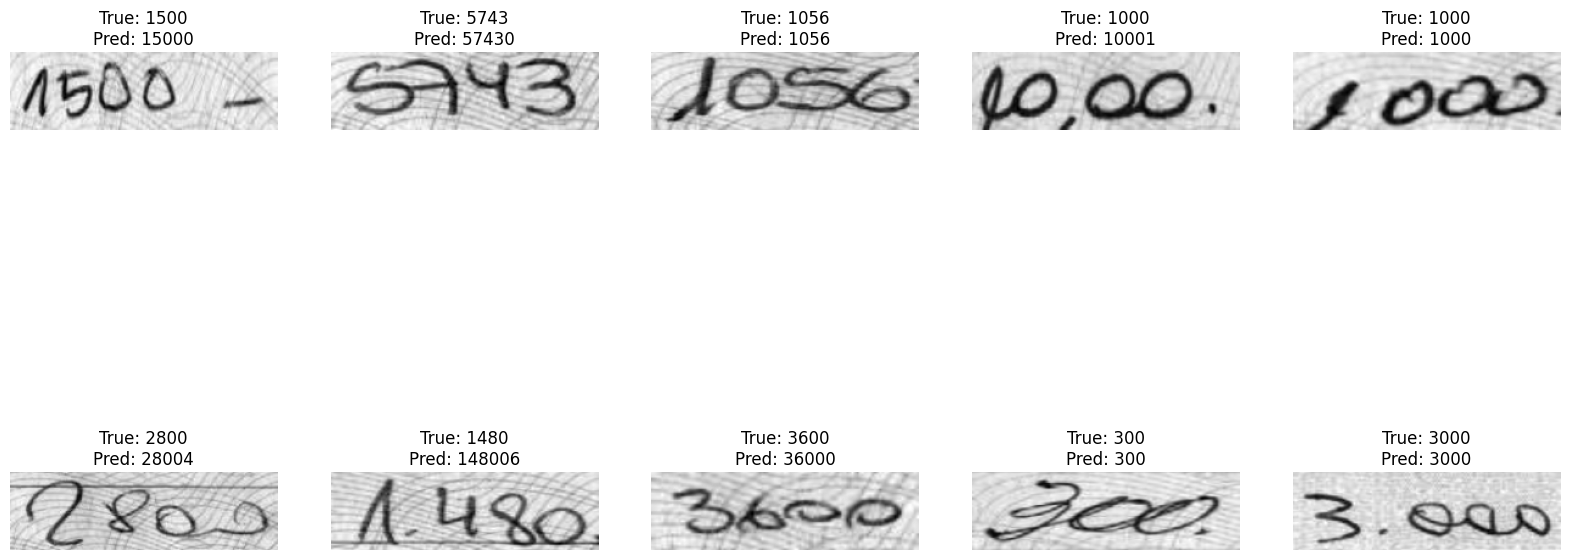

In [12]:
# Function to decode predictions using CTC decoding
def decode_predictions(pred):
    input_length = np.ones(pred.shape[0]) * pred.shape[1]
    decoded = K.ctc_decode(pred, input_length=input_length)[0][0]
    return K.get_value(decoded)

# Function to convert digit sequences to text
def convert_to_text(digits):
    text = []
    for digit_seq in digits:
        text_seq = ''.join([char_list[int(digit)] for digit in digit_seq if digit != -1])
        text.append(text_seq)
    return text

# Load the trained model weights
act_model.load_weights(filepath)

# Get predictions
pred = act_model.predict(valid_images)

# Decode predictions
decoded_preds = decode_predictions(pred)

# Convert decoded predictions to text
pred_texts = convert_to_text(decoded_preds)

# Convert ground truth labels to text
valid_texts = convert_to_text(valid_labels)

# Function to plot images with their true and predicted labels
def plot_images_with_labels(images, true_labels, pred_labels, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].reshape(64, 220), cmap='gray')
        plt.title(f"True: {true_labels[i]}\nPred: {pred_labels[i]}")
        plt.axis('off')
    plt.show()

# Display images with true and predicted labels
num_display = 10
plot_images_with_labels(valid_images, valid_texts, pred_texts, num_display)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


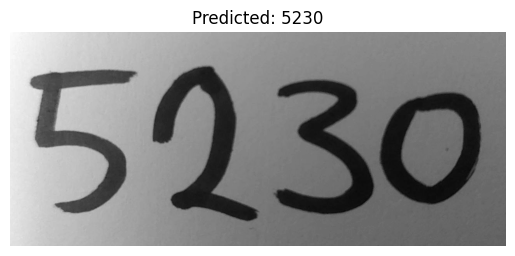

In [9]:
# Preprocess the image
def preprocess_image(img_path, target_h=64, target_w=220):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (target_w, target_h))
    img = img.astype('float32')
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Decode the predictions
def decode_predictions(pred):
    input_length = np.ones(pred.shape[0]) * pred.shape[1]
    decoded = K.ctc_decode(pred, input_length=input_length)[0][0]
    return K.get_value(decoded)

# Convert decoded predictions to text
def convert_to_text(digits):
    text = []
    for digit_seq in digits:
        text_seq = ''.join([char_list[int(digit)] for digit in digit_seq if digit != -1])
        text.append(text_seq)
    return text

# Path to your uploaded image
uploaded_image_path = "/content/pict.png"

# Preprocess the uploaded image
processed_image = preprocess_image(uploaded_image_path)

# Load the trained model
model_path = "./model_crnn.h5"
act_model.load_weights(model_path)

# Predict the label for the uploaded image
prediction = act_model.predict(processed_image)

# Decode the prediction
decoded_prediction = decode_predictions(prediction)

# Convert the decoded prediction to text
predicted_text = convert_to_text(decoded_prediction)[0]

# Display the uploaded image with the predicted label
img = cv2.imread(uploaded_image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.title(f"Predicted: {predicted_text}")
plt.axis('off')
plt.show()

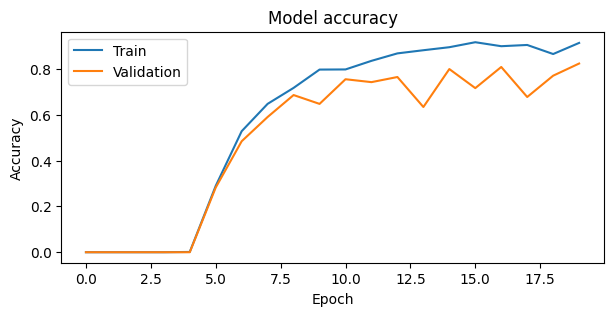

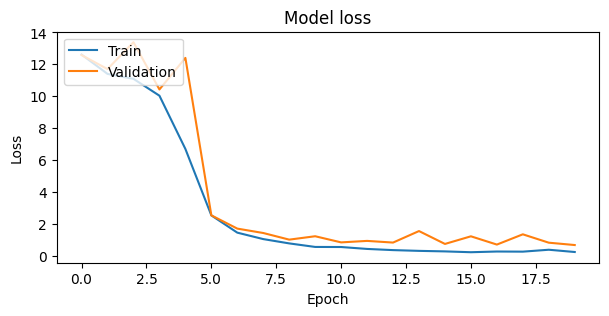

210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step


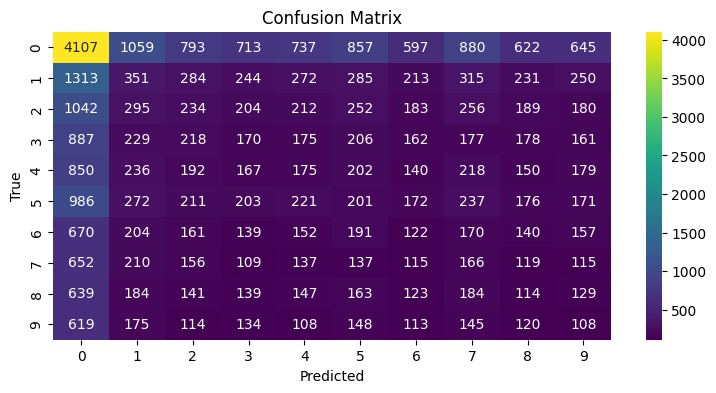

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.37      0.36     11010
           1       0.11      0.09      0.10      3758
           2       0.09      0.08      0.08      3047
           3       0.08      0.07      0.07      2563
           4       0.07      0.07      0.07      2509
           5       0.08      0.07      0.07      2850
           6       0.06      0.06      0.06      2106
           7       0.06      0.09      0.07      1916
           8       0.06      0.06      0.06      1963
           9       0.05      0.06      0.06      1784

    accuracy                           0.17     33506
   macro avg       0.10      0.10      0.10     33506
weighted avg       0.17      0.17      0.17     33506



In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(7, 3))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(7, 3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Generate predictions and convert them to text
y_pred = act_model.predict(valid_images)
decoded_labels = K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0]) * y_pred.shape[1])[0][0]

# Convert predictions to strings
out = K.get_value(decoded_labels)
predictions = []
for i in range(len(out)):
    pred = ""
    for j in range(len(out[i])):
        if int(out[i][j]) != -1:
            pred += char_list[int(out[i][j])]
    predictions.append(pred)

# Confusion matrix and classification report
y_true = []
for label in valid_labels:
    y_true.append(''.join([char_list[idx] for idx in label]))

# Flatten the lists to create a single list of characters for confusion matrix and classification report
y_true_flat = [char for label in y_true for char in label]
y_pred_flat = [char for pred in predictions for char in pred]

# Ensure y_true_flat and y_pred_flat have the same length
min_length = min(len(y_true_flat), len(y_pred_flat))
y_true_flat = y_true_flat[:min_length]
y_pred_flat = y_pred_flat[:min_length]

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat, labels=list(char_list))
conf_matrix_df = pd.DataFrame(conf_matrix, index=list(char_list), columns=list(char_list))

# Plot confusion matrix
plt.figure(figsize=(9, 4))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
class_report = classification_report(y_true_flat, y_pred_flat, labels=list(char_list), target_names=list(char_list))
print('Classification Report:')
print(class_report)